In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import sys
import datetime
import glob
#import shutil
import pandas as pd
import math

import subprocess

import TCam_beam_center_lib as mf

from csv import writer

import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

mpl.rcParams['xtick.labelsize'] = 40
mpl.rcParams['ytick.labelsize'] = 40
mpl.rcParams["axes.labelsize"] = 40
mpl.rcParams["axes.titlesize"] = 40
mpl.rcParams["legend.fontsize"] = 40

mpl.rcParams['axes.linewidth'] = 10


######################################
# Calibration factor for each mirro
###################################### 
# 2022/08/22~
# [pixel]
# ETMX_r_pre = 1246
# ETMY_r_pre = 1248
# ITMX_r_pre = 630
# ITMY_r_pre = 640
mirror_r_pre = 110 # [mm]

#
# return calibration factor pixel to mm
#
def calibration_factor_pixel2mm(mirror_name, r_mirror):
    factor = 0.0
    if mirror_name == "ETMX":
        factor = mirror_r_pre / r_mirror
    elif mirror_name == "ETMY":
        factor = mirror_r_pre / r_mirror
    elif mirror_name == "ITMX":
        factor = mirror_r_pre / r_mirror
    elif mirror_name == "ITMY":
        factor = mirror_r_pre / r_mirror
    else:
        print("%s is not supported." % mirror_name)
    return factor

#
# extract gain and exposure time from configuration file of TCam
#
def get_gain_T(dirname, figname):
    tmp = figname.split(".")[0].split("_")[3:6]
    date = "-".join(tmp)

    config_file = dirname + "/" + figname.split(".")[0] + ".txt"
    #print(config_file)
    
    with open(config_file, 'r') as outfile:
        lines = outfile.readlines()
        outfile.close()

        gain = 0
        T = 0
        lines = [line.strip() for line in lines]        
        for line in lines:
            if "controls_[3]_value_milliseconds" in line:
                T = line.split(" ")[1]

            if "controls_[2]_value" in line:
                gain = line.split(" ")[1]
    gain = math.ceil(int(gain))
    T    = math.ceil(float(T))
    return gain, T


    

    

def fit_image(outdirname, outdirname_sym, dirname, dir_base_fit,
              figname, mirror_name, gain, T, x_mirror, y_mirror, r_mirror,
              x_err_mirror, y_err_mirror, n_slice = 250, threshold_center_error = 100, flag_output=False):

    # この範囲のデータはフィットデータから取り除く
    x_crop_min = 2080
    x_crop_max = 3400
    y_crop_min = 820
    y_crop_max = 1700    
    
    #n_tile_vertical = 8
    n_tile_horizon  = 8
    step  = 1
    x0    = 0    
    fname="%s/%s" % (dirname, figname)   
    
    img_full = cv2.imread(fname, cv2.IMREAD_UNCHANGED)
    height, width, _ = img_full.shape    
    img_gray = cv2.cvtColor(img_full, cv2.COLOR_BGR2GRAY)
    img      = np.array(img_gray, dtype=float)

    # image filtering method
    img_ftr = mf.twoD_LowPass(img)
    if flag_output:
        fname="%s/lp_%s" % (outdirname, figname)
        cv2.imwrite(fname, img_ftr)
    
    char_axis = ["y", "x"]
    directions = ['yoko', 'tate']
    return_values = np.zeros(4)
    center_values_slice = {}
    center_values_ave = {}
    center_values_err = {}
    
    for ax_slice in range(2):
        cut_direction = directions[ax_slice]
        fit_results = []

        # 鏡の内側のみをフィットに使う(pcalをフィットに使わないため)
        r_half = r_mirror/3
        if char_axis[ax_slice] == "x":
            slices = np.linspace(int(y_mirror-r_half), int(y_mirror+r_half), n_slice)
        if char_axis[ax_slice] == "y":
            slices = np.linspace(int(x_mirror-r_half), int(x_mirror+r_half), n_slice)

        n_tile_vertical = math.ceil(len(slices) / n_tile_horizon)   
            
        fig = plt.figure(figsize=[80, n_tile_vertical*10])
        
        for i_slice in range(n_slice):
#            xdata, ydata, index = mf.get_fitting_data(img, img_ftr, ax_slice, x_slice[i_slice])

            ii_slice = int(slices[i_slice])
            if cut_direction == 'yoko': # y = y_0 で切った時のデータをフィットする。横に切る
                ydata     = img[ii_slice,:]
                ydata_ftr = img_ftr[ii_slice,:]
                fit_color = 'pink'                
            elif cut_direction == 'tate':  # x = x_0 で切った時のデータをフィットする。縦に切る
                ydata     = img[:, ii_slice]
                ydata_ftr = img_ftr[:, ii_slice]
                fit_color = 'cyan'
            xdata = np.arange(len(ydata))
            index = np.ones(len(ydata), dtype=bool)
            # ydata > ydata_ftr の部分のデータを落とす   
            index[ydata > ydata_ftr] = False 
    
            xdata_fit = xdata[index]
            ydata_fit = ydata[index]

            popt, pcov = mf.get_peak(xdata_fit, ydata_fit)
            center_err = np.diag(pcov)[2]
            
            plt.subplot(n_tile_vertical, n_tile_horizon, i_slice+1)        

            plt.plot(xdata_fit, ydata_fit, label="%s=%d" % (char_axis[ax_slice], ii_slice), c="blue", marker="x",
                 markersize=10, markeredgewidth=4, linewidth=0)                                                         
            
            # if len(xdata_fit) > 50:
            #print(center_err)
            if(center_err < threshold_center_error):
                result = []
                result.append(slices[i_slice]) # これが今のsliceの値
                for i in range(len(popt)):
                    result.append(popt[i]) # 最初のフィットパラメーター [amplitude, width, center, background]
                    result.append(np.diag(pcov)[i]) # 標準偏差 std error
                fit_results.append(result)
                # fit_results = [slice, amplitude, amplitude_error, width, width_error, center, center_error,
                # background, background_error]
                print(result)

                plt.plot(np.array(xdata), mf.ClippedGaussian(xdata, *popt), c=fit_color, linewidth=4)
                plt.vlines(popt[2], 0, 255, "red", label="center = %d" % popt[2], linestyles='dashed', linewidth=4) # vlines        
            plt.legend()


        fig.patch.set_facecolor('white')
        outname = "fit_%s_%s.png" % (figname.split(".")[0], cut_direction)
        plt.savefig(outname, bbox_inches='tight', pad_inches=0.5)
                            
        x, dx = mf.get_average(fit_results)
        # print("%s = %.2f +/- %.2f" % (char_axis[ax_slice], x, dx))
        return_values[2*ax_slice] = x
        return_values[2*ax_slice+1] = dx

        # fit_results = [slice, amplitude, amplitude_error, width, width_error, center, center_error, bias, bias_error]
        center_values_slice["%s" % char_axis[ax_slice]] = [r[0] for r in fit_results]
        center_values_ave["%s" % char_axis[ax_slice]]   = [r[5] for r in fit_results]
        center_values_err["%s" % char_axis[ax_slice]]   = [r[6] for r in fit_results]
        
        #
        # make histogram
        #
        # fig = plt.figure(figsize=[12, 6])
        # fig.patch.set_facecolor('white')
        # plt.hist(center_values_ave["%s" % char_axis[ax_slice]], bins=40)
        # plt.savefig("./hist_%s.png" % char_axis[ax_slice])
        # plt.close()    

#         for i in range(len(center_values_slice["%s" % char_axis[ax_slice]])):
#             print("%f  +/-  %f" %
#                   (center_values_ave["%s" % char_axis[ax_slice]][i],
#                    center_values_err["%s" % char_axis[ax_slice]][i]))
        
        
    #
    # make error bar plot of fitting
    #
    # fig = plt.figure(figsize=[12, 6])
    # fig.patch.set_facecolor('white')
    # x  = center_values_ave["x"]
    # xerr = center_values_err["x"]
    # y  = center_values_slice["x"]
    # plt.errorbar(x, y, xerr = xerr, capsize=3, fmt='o', markersize=3, ecolor='magenta',
    #              markeredgecolor = "magenta", color='w')
    # x  = center_values_slice["y"]
    # y  = center_values_ave["y"]
    # yerr = center_values_err["y"]
    # plt.errorbar(x, y, yerr = yerr, capsize=3, fmt='o', markersize=3, ecolor='blue',
    #              markeredgecolor = "blue", color='w')
    # plt.xlim(0, width)
    # plt.ylim(height, 0)
    # plt.savefig("./error_bar_%s.png" % char_axis[ax_slice])
    # plt.close()           


    
    x     = return_values[0]
    x_err = return_values[1]
    y     = return_values[2]
    y_err = return_values[3]

    #
    # extract date when TCam took the figure
    #
    year = figname.split("_")[3]
    mm   = figname.split("_")[4][0:2]
    dd   = figname.split("_")[4][2:4]
    hour = figname.split("_")[5][0:2]
    minute = figname.split("_")[5][2:4]
    second = figname.split("_")[5][4:6]
    date = year + "/" + mm + "/" + dd + " " + hour + ":" + minute     
    
    fname="%s/%s" % (dirname, figname)
    img_estimated = cv2.imread(fname, cv2.IMREAD_UNCHANGED)    
    # mirror center of circle with magenta
    center=(int(x_mirror), int(y_mirror))
    #img_estimated =cv2.circle(img_estimated, center=center, radius=8, color=(255, 0, 255),
    img_estimated =cv2.circle(img_estimated, center=center, radius=8, color=(0, 255, 0),
                              thickness=-1, lineType=cv2.LINE_4, shift=0)
    # large circle for mirror edge with magenta
    #img_estimated =cv2.circle(img_estimated, center=center, radius=int(r_mirror), color=(255, 0, 255),
    img_estimated =cv2.circle(img_estimated, center=center, radius=int(r_mirror), color=(0, 255, 0),
                              thickness=3, lineType=cv2.LINE_4, shift=0)
    # beam center of circle with lime
    center=(int(x), int(y))
    img_estimated =cv2.circle(img_estimated, center=center, radius=8, color=(0, 0, 255),
           thickness=-1, lineType=cv2.LINE_4, shift=0)

    calibration = calibration_factor_pixel2mm(mirror_name, r_mirror)
    diff_x_mm = (x - x_mirror) * calibration
    diff_y_mm = (y - y_mirror) * calibration
    
    # text in left bottom
    cv2.putText(img_estimated, 'Taken at %s (%s)' % (date, mirror_name), (100, int(height*0.89)), cv2.FONT_HERSHEY_PLAIN, fontScale=4.0, color=(255, 0, 255), thickness=5)    
    cv2.putText(img_estimated, 'gain = %s, T = %s [ms]' % (gain, T), (100, int(height*0.91)), cv2.FONT_HERSHEY_PLAIN, fontScale=4.0, color=(255, 0, 255), thickness=5)    
    
    cv2.putText(img_estimated, 'mirror center = (%.1f +/- %.1f, %.1f +/- %.1f), radius = %.1f +/- %.1f' % (x_mirror, x_err_mirror, y_mirror, y_err_mirror, r_mirror, 0),
            (100, int(height*0.93)), cv2.FONT_HERSHEY_PLAIN, fontScale=4.0, color=(0, 255, 0), thickness=5)
    cv2.putText(img_estimated, '    Beam center = (%.1f +/- %.1f, %.1f +/- %.1f)' % (x, x_err, y, y_err),
            (100, int(height*0.95)), cv2.FONT_HERSHEY_PLAIN, fontScale=4.0, color=(0, 0, 255), thickness=5)
    cv2.putText(img_estimated, 'diff from mirror center to beam center [mm] = (%.1f, %.1f)' % (diff_x_mm, diff_y_mm),
            (100, int(height*0.97)), cv2.FONT_HERSHEY_PLAIN, fontScale=4.0, color=(255, 0, 255), thickness=5)
    
    # save fig as png
    tmp = figname.split(".")[0] + "_beam_center.png"
    fname="%s/%s" % (outdirname, tmp)
    cv2.imwrite(fname, img_estimated)


    

    
    #
    # make intermediate plots
    #
    fname="%s/%s" % (dirname, figname)
    img_estimated = cv2.imread(fname, cv2.IMREAD_UNCHANGED)    
    # mirror center of circle with magenta
    center=(int(x_mirror), int(y_mirror))
    #img_estimated =cv2.circle(img_estimated, center=center, radius=8, color=(255, 0, 255),
    img_estimated =cv2.circle(img_estimated, center=center, radius=8, color=(0, 255, 0),
                              thickness=-1, lineType=cv2.LINE_4, shift=0)
    # large circle for mirror edge with magenta
    #img_estimated =cv2.circle(img_estimated, center=center, radius=int(r_mirror), color=(255, 0, 255),
    img_estimated =cv2.circle(img_estimated, center=center, radius=int(r_mirror), color=(0, 255, 0),
                              thickness=3, lineType=cv2.LINE_4, shift=0)
    # beam center of circle with lime
    center=(int(x), int(y))
    img_estimated =cv2.circle(img_estimated, center=center, radius=8, color=(0, 0, 255),
           thickness=-1, lineType=cv2.LINE_4, shift=0)

    calibration = calibration_factor_pixel2mm(mirror_name, r_mirror)
    diff_x_mm = (x - x_mirror) * calibration
    diff_y_mm = (y - y_mirror) * calibration
        
    # text in left bottom
    cv2.putText(img_estimated, 'Taken at %s (%s)' % (date, mirror_name), (100, int(height*0.89)), cv2.FONT_HERSHEY_PLAIN, fontScale=4.0, color=(255, 0, 255), thickness=5)    
    cv2.putText(img_estimated, 'gain = %s, T = %s [ms]' % (gain, T), (100, int(height*0.91)), cv2.FONT_HERSHEY_PLAIN, fontScale=4.0, color=(255, 0, 255), thickness=5)    
    
    cv2.putText(img_estimated, 'mirror center = (%.1f +/- %.1f, %.1f +/- %.1f), radius = %.1f +/- %.1f' % (x_mirror, x_err_mirror, y_mirror, y_err_mirror, r_mirror, 0),
            (100, int(height*0.93)), cv2.FONT_HERSHEY_PLAIN, fontScale=4.0, color=(0, 255, 0), thickness=5)
    cv2.putText(img_estimated, '    Beam center = (%.1f +/- %.1f, %.1f +/- %.1f)' % (x, x_err, y, y_err),
            (100, int(height*0.95)), cv2.FONT_HERSHEY_PLAIN, fontScale=4.0, color=(0, 0, 255), thickness=5)
    cv2.putText(img_estimated, 'diff from mirror center to beam center [mm] = (%.1f, %.1f)' % (diff_x_mm, diff_y_mm),
            (100, int(height*0.97)), cv2.FONT_HERSHEY_PLAIN, fontScale=4.0, color=(255, 0, 255), thickness=5)

    
    #
    # make error bar plot of fitting
    #
    xslice  = center_values_ave["x"]
    yslice  = center_values_slice["x"]
    for i in range(len(xslice)):
        center = (int(xslice[i]), int(yslice[i]))
        img_estimated =cv2.circle(img_estimated, center=center, radius=8, color=(255, 255, 0),
                                  thickness=-1, lineType=cv2.LINE_4, shift=0) # (255,255,0) = blue
    xslice  = center_values_slice["y"]
    yslice  = center_values_ave["y"]
    for i in range(len(xslice)):
        center = (int(xslice[i]), int(yslice[i]))
        img_estimated =cv2.circle(img_estimated, center=center, radius=8, color=(255, 255, 0),
                                  thickness=-1, lineType=cv2.LINE_4, shift=0) # (255,255,0) = blue

    # save fig as png
    tmp = figname.split(".")[0] + "_scatter.png"
    fname="%s/%s" % (outdirname, tmp)
    cv2.imwrite(fname, img_estimated)    
    
    
    
    plt.close('all') # windowを閉じないと、matplotlibが開きすぎとwarningを出すので
     
    return x, x_err, y, y_err





def create_symbolic_link(figname, outdirname, dir_base_fit, mirror_name):

    # only for Kamioka computer
    if os.path.isdir("/data2"):
        # change directory for relative symbolic link
        os.chdir(dir_base_fit)

        tmp = figname.split(".")[0] + "_beam_center.png"
        fname="%s/%s" % (outdirname, tmp)
        
        fname_sym = "latest.png"
        # update symbolic link
        if os.path.islink(fname_sym) == True:
            os.remove(fname_sym)
        tmp = "/".join(fname.split("/")[4:]) # example : '2022/0329/TCam_ETMX_01110_2022_0329_141445_fit.png'
        os.symlink(tmp, fname_sym)

        fname_sym = "latest.txt"
        # update symbolic link
        if os.path.islink(fname_sym) == True:
            os.remove(fname_sym)
        tmp = "/".join(fname.split("/")[4:]) # example : '2022/0329/TCam_ETMX_01110_2022_0329_141445_fit.png'
        tmp = tmp.replace('png', 'txt')
        os.symlink(tmp, fname_sym)
        
        # copy dat file including update time
        dir_base = dir_base_fit.replace('TCam_fit', 'TCam') # example : '/data2/TCam/ETMX'
        #shutil.copy('%s/lastupdate.txt' % dir_base, '%s/lastupdate.txt' % dir_base_fit)        
        cmd='cp %s/lastupdate.txt %s/lastupdate.txt > /dev/null 2>&1' % (dir_base, dir_base_fit)
        subprocess.run(cmd, shell=True)

        # make thumbnail figure
        cmd='cwebp -resize 518 0 -o thumb.webp %s > /dev/null 2>&1' % fname
        subprocess.run(cmd, shell=True)


#
# save fitting results as text and csv files
#
def save_textfile(figname, dir_base_fit, x, y, x_err, y_err,
                  x_mirror, y_mirror, r_mirror, x_err_mirror, y_err_mirror,
                  gain, T, mirror_name):

    #
    # Output result as text file (overwrite)
    #            
    textname="%s/%s_beam_center.txt" % (outdirname, figname.split(".")[0])
    with open(textname, 'w') as outfile: # a : 追記モード, w : 上書きモード
        dt_now = datetime.datetime.now()

        calibration = calibration_factor_pixel2mm(mirror_name, r_mirror)

        #line="%s %.2f %.2f %.2f %s %s %.2f %.2f %.2f\n" % (date, x, y, r, T, gain, x_err, y_err, r_err)
        line = "%s\n" % dt_now
        line = line + "gain %d\n" % gain
        line = line + "exposure_time[ms] %d\n" % T
        line = line + "x_mirror_center %.2f\n" % x_mirror
        line = line + "y_mirror_center %.2f\n" % y_mirror
        line = line + "x_err_mirror_center %.2f\n" % x_err_mirror
        line = line + "y_err_mirror_center %.2f\n" % y_err_mirror
        line = line + "r %.2f\n" % r_mirror
        line = line + "\n"
        line = line + "x_beam_center %.2f\n" % x
        line = line + "y_beam_center %.2f\n" % y
        line = line + "x_err_beam_center %.2f\n" % x_err
        line = line + "y_err_beam_center %.2f\n" % y_err
        line = line + "\n"
        line = line + "diff_x_beam-center[mm] %.2f\n" % ((x - x_mirror) * calibration)
        line = line + "diff_y_beam-center[mm] %.2f\n" % ((y - y_mirror) * calibration)
        outfile.write(line)
        outfile.close

    # only for Kamioka machine
    if os.path.isdir("/data2"):
        #
        # save header for csv
        # only for the first time
        #
        csvname="%s/archive/fit_beam_center_%s.csv" % (dir_base_fit, mirror_name)
        if not os.path.exists(csvname):
            csvline_header=["fitting date", "gain", "T", "x_beam", "y_beam", "x_error", "y_error", "x_mirror", "y_mirror", "r_mirror", "filename"]
            with open(csvname, 'a', newline='') as f:      
                writer_object = writer(f)
                writer_object.writerow(csvline_header)  
                f.close()            

        #
        # If the result for same figure is in csv file,
        # comment out past result by adding #, and add latest result in the bottom
        #
        if os.path.isfile(csvname):
            df = pd.read_csv(csvname)
            #
            # list of past reulsts for same TCam photo
            #
            ll = df[df["filename"] == figname]

            if len(ll) == 0: # first fitting
                with open(csvname, 'a', newline='') as f:  
                    writer_object = writer(f)
                    csvline=[dt_now, gain, T, x, y, x_err, y_err, x_mirror, y_mirror, r_mirror, figname]
                    writer_object.writerow(csvline)
                    f.close()        

            else: # not first fitting
                for i in list(ll.index):
                    # df.loc[df.index==i, ["x"]] = 10
                    # df.loc[df.index==i, ["y"]] = 10
                    df.loc[df.index==i, ["fitting date"]] = "#" + df.loc[df.index==i, ["fitting date"]]
                    
                # number of fitting
                n = len(df["gain"])
                #print(n)
                line_to_add = ll.iloc[-1].values # copy last fitting result
                df.loc[n] = line_to_add

                #
                # update the values to the latest one
                #
                df.loc[n, ["x"]] = x
                df.loc[n, ["y"]] = y
                df.loc[n, ["x_error"]] = x_err
                df.loc[n, ["y_error"]] = y_err
                df.loc[n, ["x_mirror"]] = x_mirror
                df.loc[n, ["y_mirror"]] = y_mirror
                df.loc[n, ["r_mirror"]] = r_mirror

                # save as csv (overwrite)
                df.to_csv(csvname, index=False)

            #if os.path.isfile(csvname):
            # csvname2="/mnt/cds_nfs/TCam/fit_value_%s.csv" % (mirror_name)            
            # cmd='cp %s %s > /dev/null 2>&1' % (csvname, csvname2)
            # subprocess.run(cmd, shell=True)

def dump_error_message_and_exit(message, dir_base_fit):
    print(message)

    if os.path.isdir("/data2"):
        cmd='echo "%s" > %s/lastupdate.txt' % (message, dir_base_fit)
        subprocess.run(cmd, shell=True)
    sys.exit(1)


def get_latest_mirror_center(dir_base_fit, mirror_name):

    csvname="%s/archive/fit_value_%s.csv" % (dir_base_fit, mirror_name)
    if os.path.exists(csvname):
        df = pd.read_csv(csvname)
        x_mirror = df.iloc[-1]["x"]
        y_mirror = df.iloc[-1]["y"]
        x_err_mirror = df.iloc[-1]["x_error"]
        y_err_mirror = df.iloc[-1]["y_error"]
        r_mirror = df.iloc[-1]["r"]
    else:
        x_err_mirror = 0
        y_err_mirror = 0
        if mirror_name == "ETMX":
            # 2022/08/29~
            x_mirror = 1925
            y_mirror = 1410
            r_mirror = 1246
        elif mirror_name == "ETMY":
            # 2022/08/29~
            x_mirror = 2220
            y_mirror = 980
            r_mirror = 1248
        elif mirror_name == "ITMX":
            # 2022/08/29~
            x_mirror = 1825
            y_mirror = 1363
            r_mirror = 630
        elif mirror_name == "ITMY":
            # 2022/08/29~
            x_mirror = 2451
            y_mirror = 1273
            r_mirror = 640
        else:
            x_mirror = 0
            y_mirror = 0
            r_mirror = 0
            
    return x_mirror, y_mirror, x_err_mirror, y_err_mirror, r_mirror


In [3]:
#input_figname="./TCam_ITMX_10110_2022_0829_000157.png"
#input_figname="./TCam_ITMX_10100_2022_0817_223126.png"
#input_figname="./TCam_ITMX_10100_2022_0817_223602.png"
#input_figname="./TCam_ITMX_10100_2022_0817_223715.png"

input_figname="./TCam_ETMX_10100_2022_0817_223127.png"
input_figname="/Users/yuzurihara/Desktop/a/fit/0927/TCam_ETMY_10110_2022_0927_100311.png"
input_figname="/Users/yuzurihara/Desktop/a/fit/0927/TCam_ETMY_11110_2022_0927_100252.png"

2220 980 0 0 1248


/Users/yuzurihara/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/yuzurihara/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in long_scalars
  ret = ret / rcount


[564.0, 11.844801509319758, 0.0417665164302417, 138.00000000000003, 4.107655339506696, 879.2711869611367, 2.7302267796901245, 2.686599626314603, 0.001506635841442803]
[580.9795918367347, 14.130475198368229, 0.04552493706000226, 116.00000000000001, 2.0573933958542336, 878.5651301339443, 1.6775613471400939, 2.8029207055724648, 0.001325923561631726]
[597.9591836734694, 13.549469560849058, 0.03688762044330114, 119.7000000000003, 2.098553018122618, 879.2097891681818, 1.8881078673763372, 2.8388294848694495, 0.0012860436984217366]
[614.9387755102041, 13.681004879664348, 0.035863663139832594, 122.70000000000002, 2.550105456179649, 884.1499349897581, 1.9827165678048984, 2.8998172333201095, 0.0015940918949352472]
[631.9183673469388, 13.59206662914822, 0.032592791448988336, 124.80000000000001, 2.550915910889891, 876.3261169093093, 2.081137351842905, 2.9028698607569714, 0.0014843435928454524]
[648.8979591836735, 13.301631413572183, 0.019605154340450293, 125.80000000000096, 2.357311164006513, 873.4

ValueError: cannot convert float NaN to integer

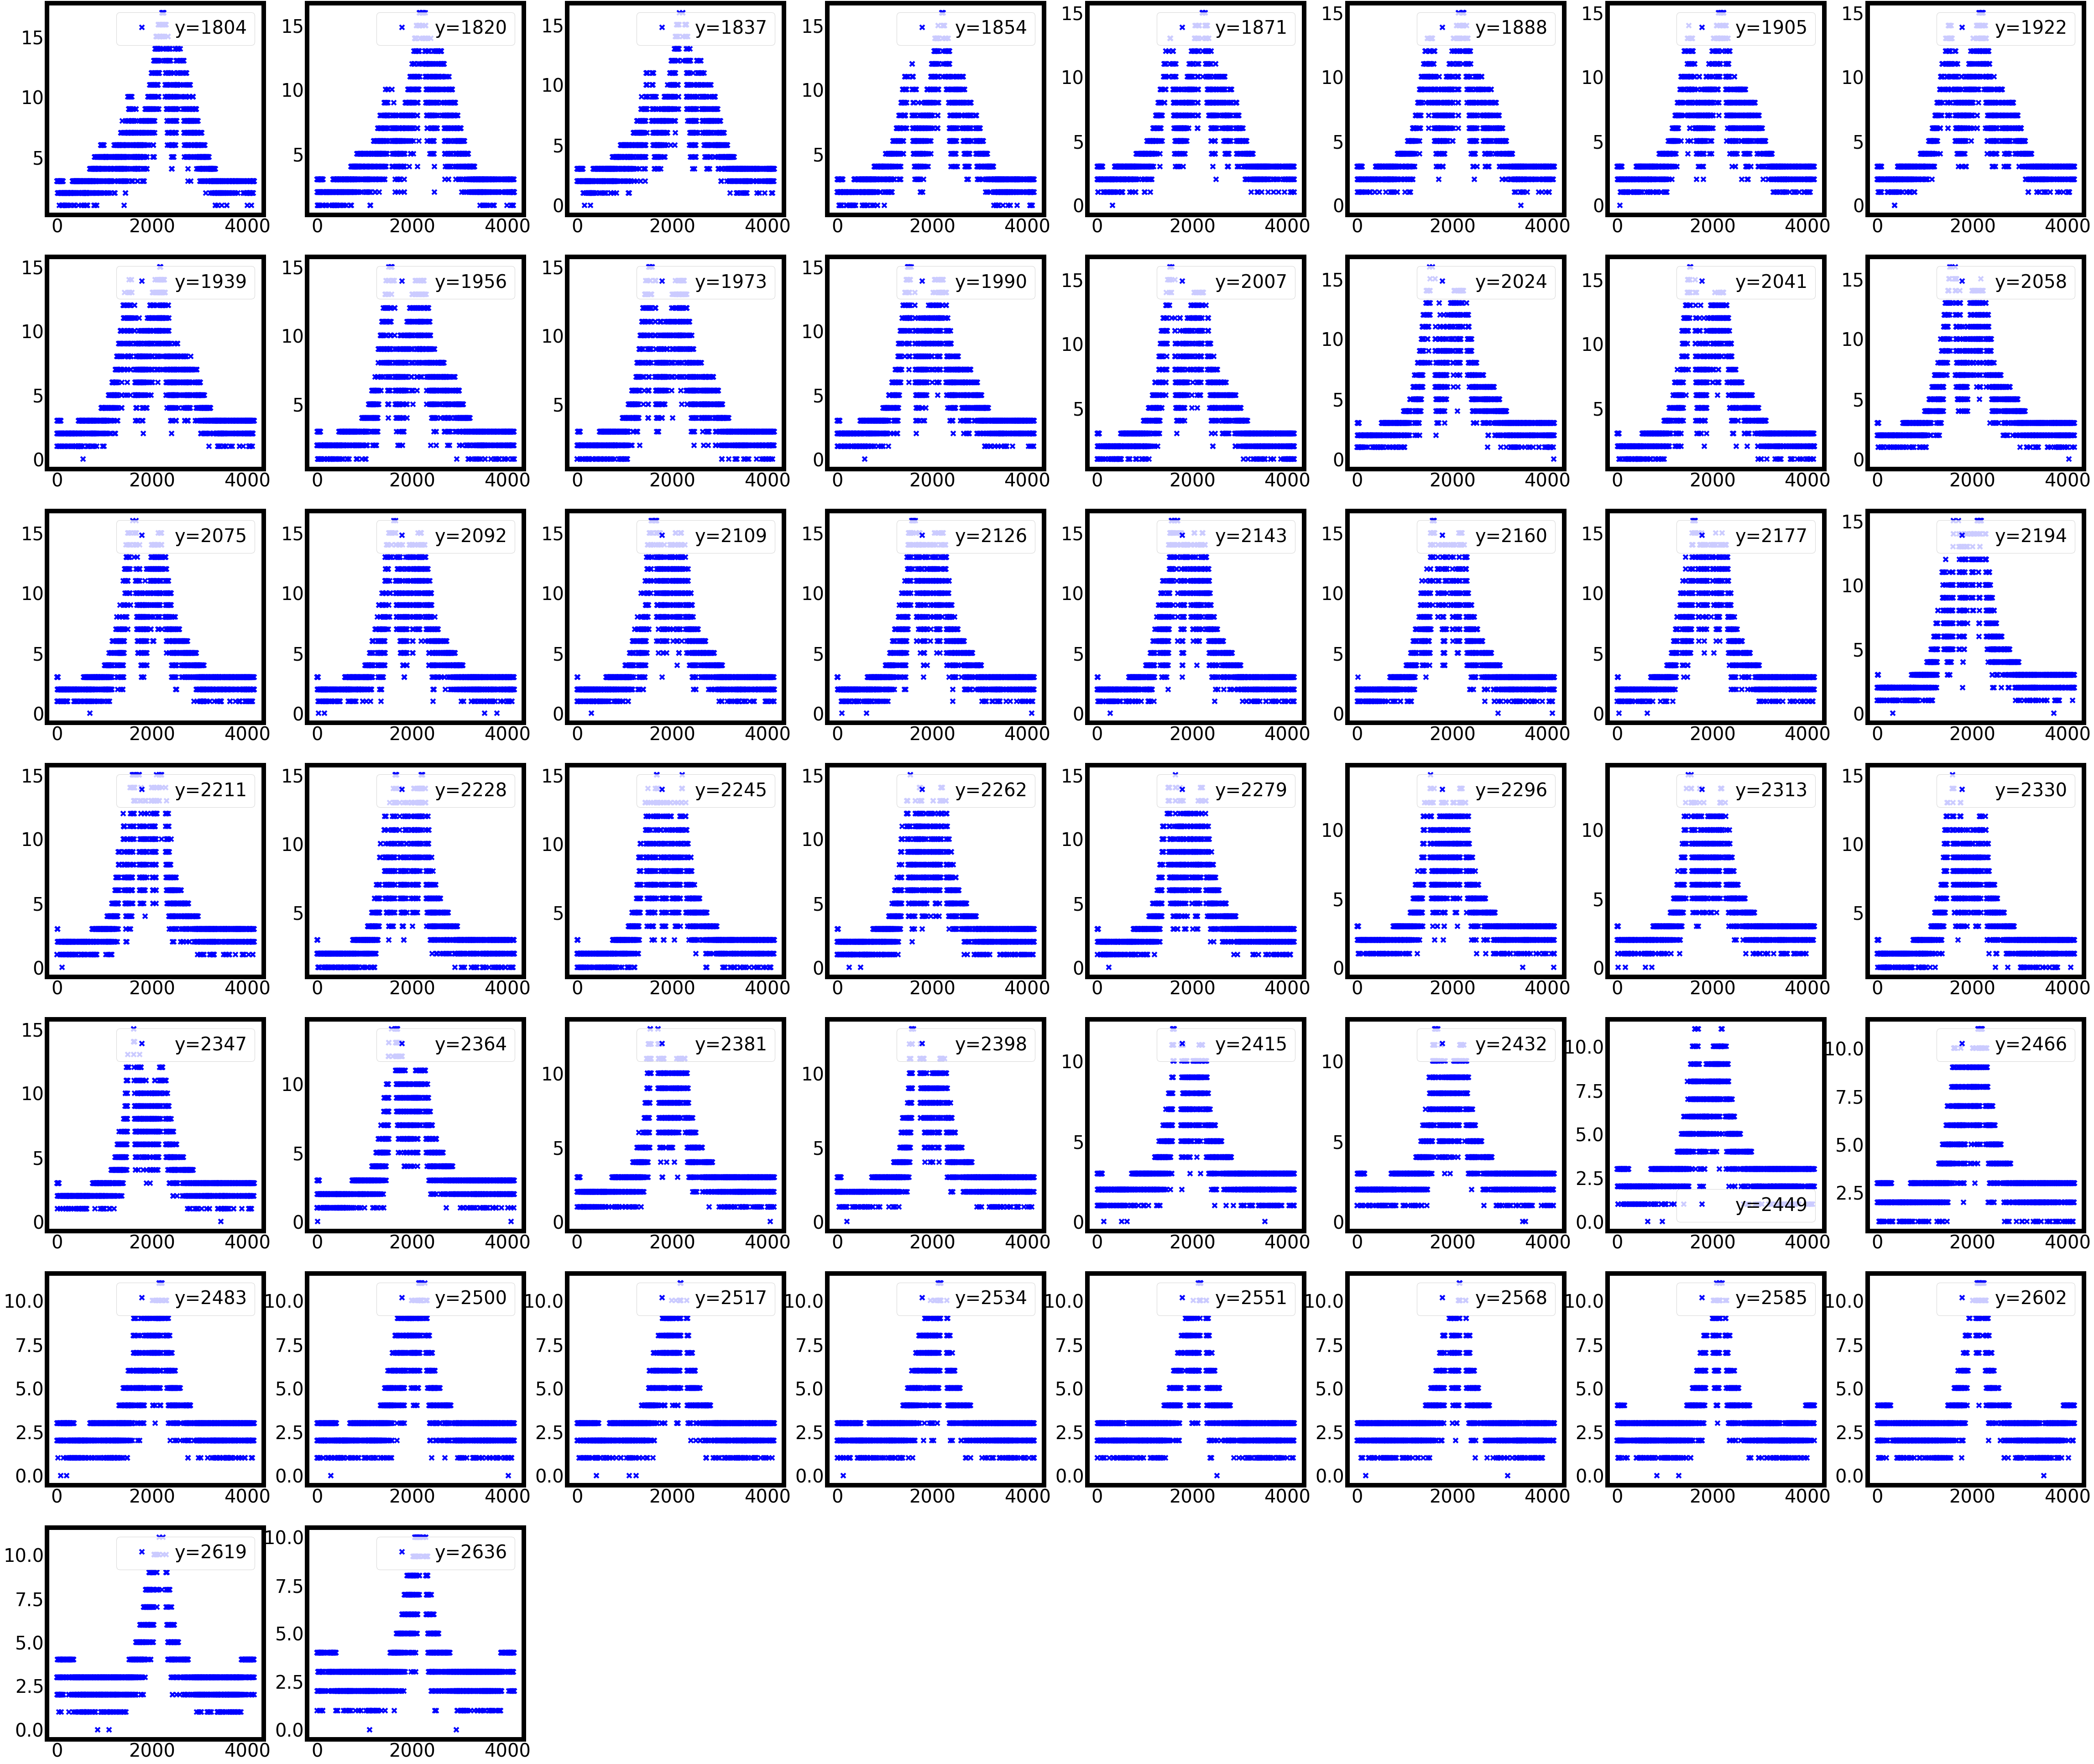

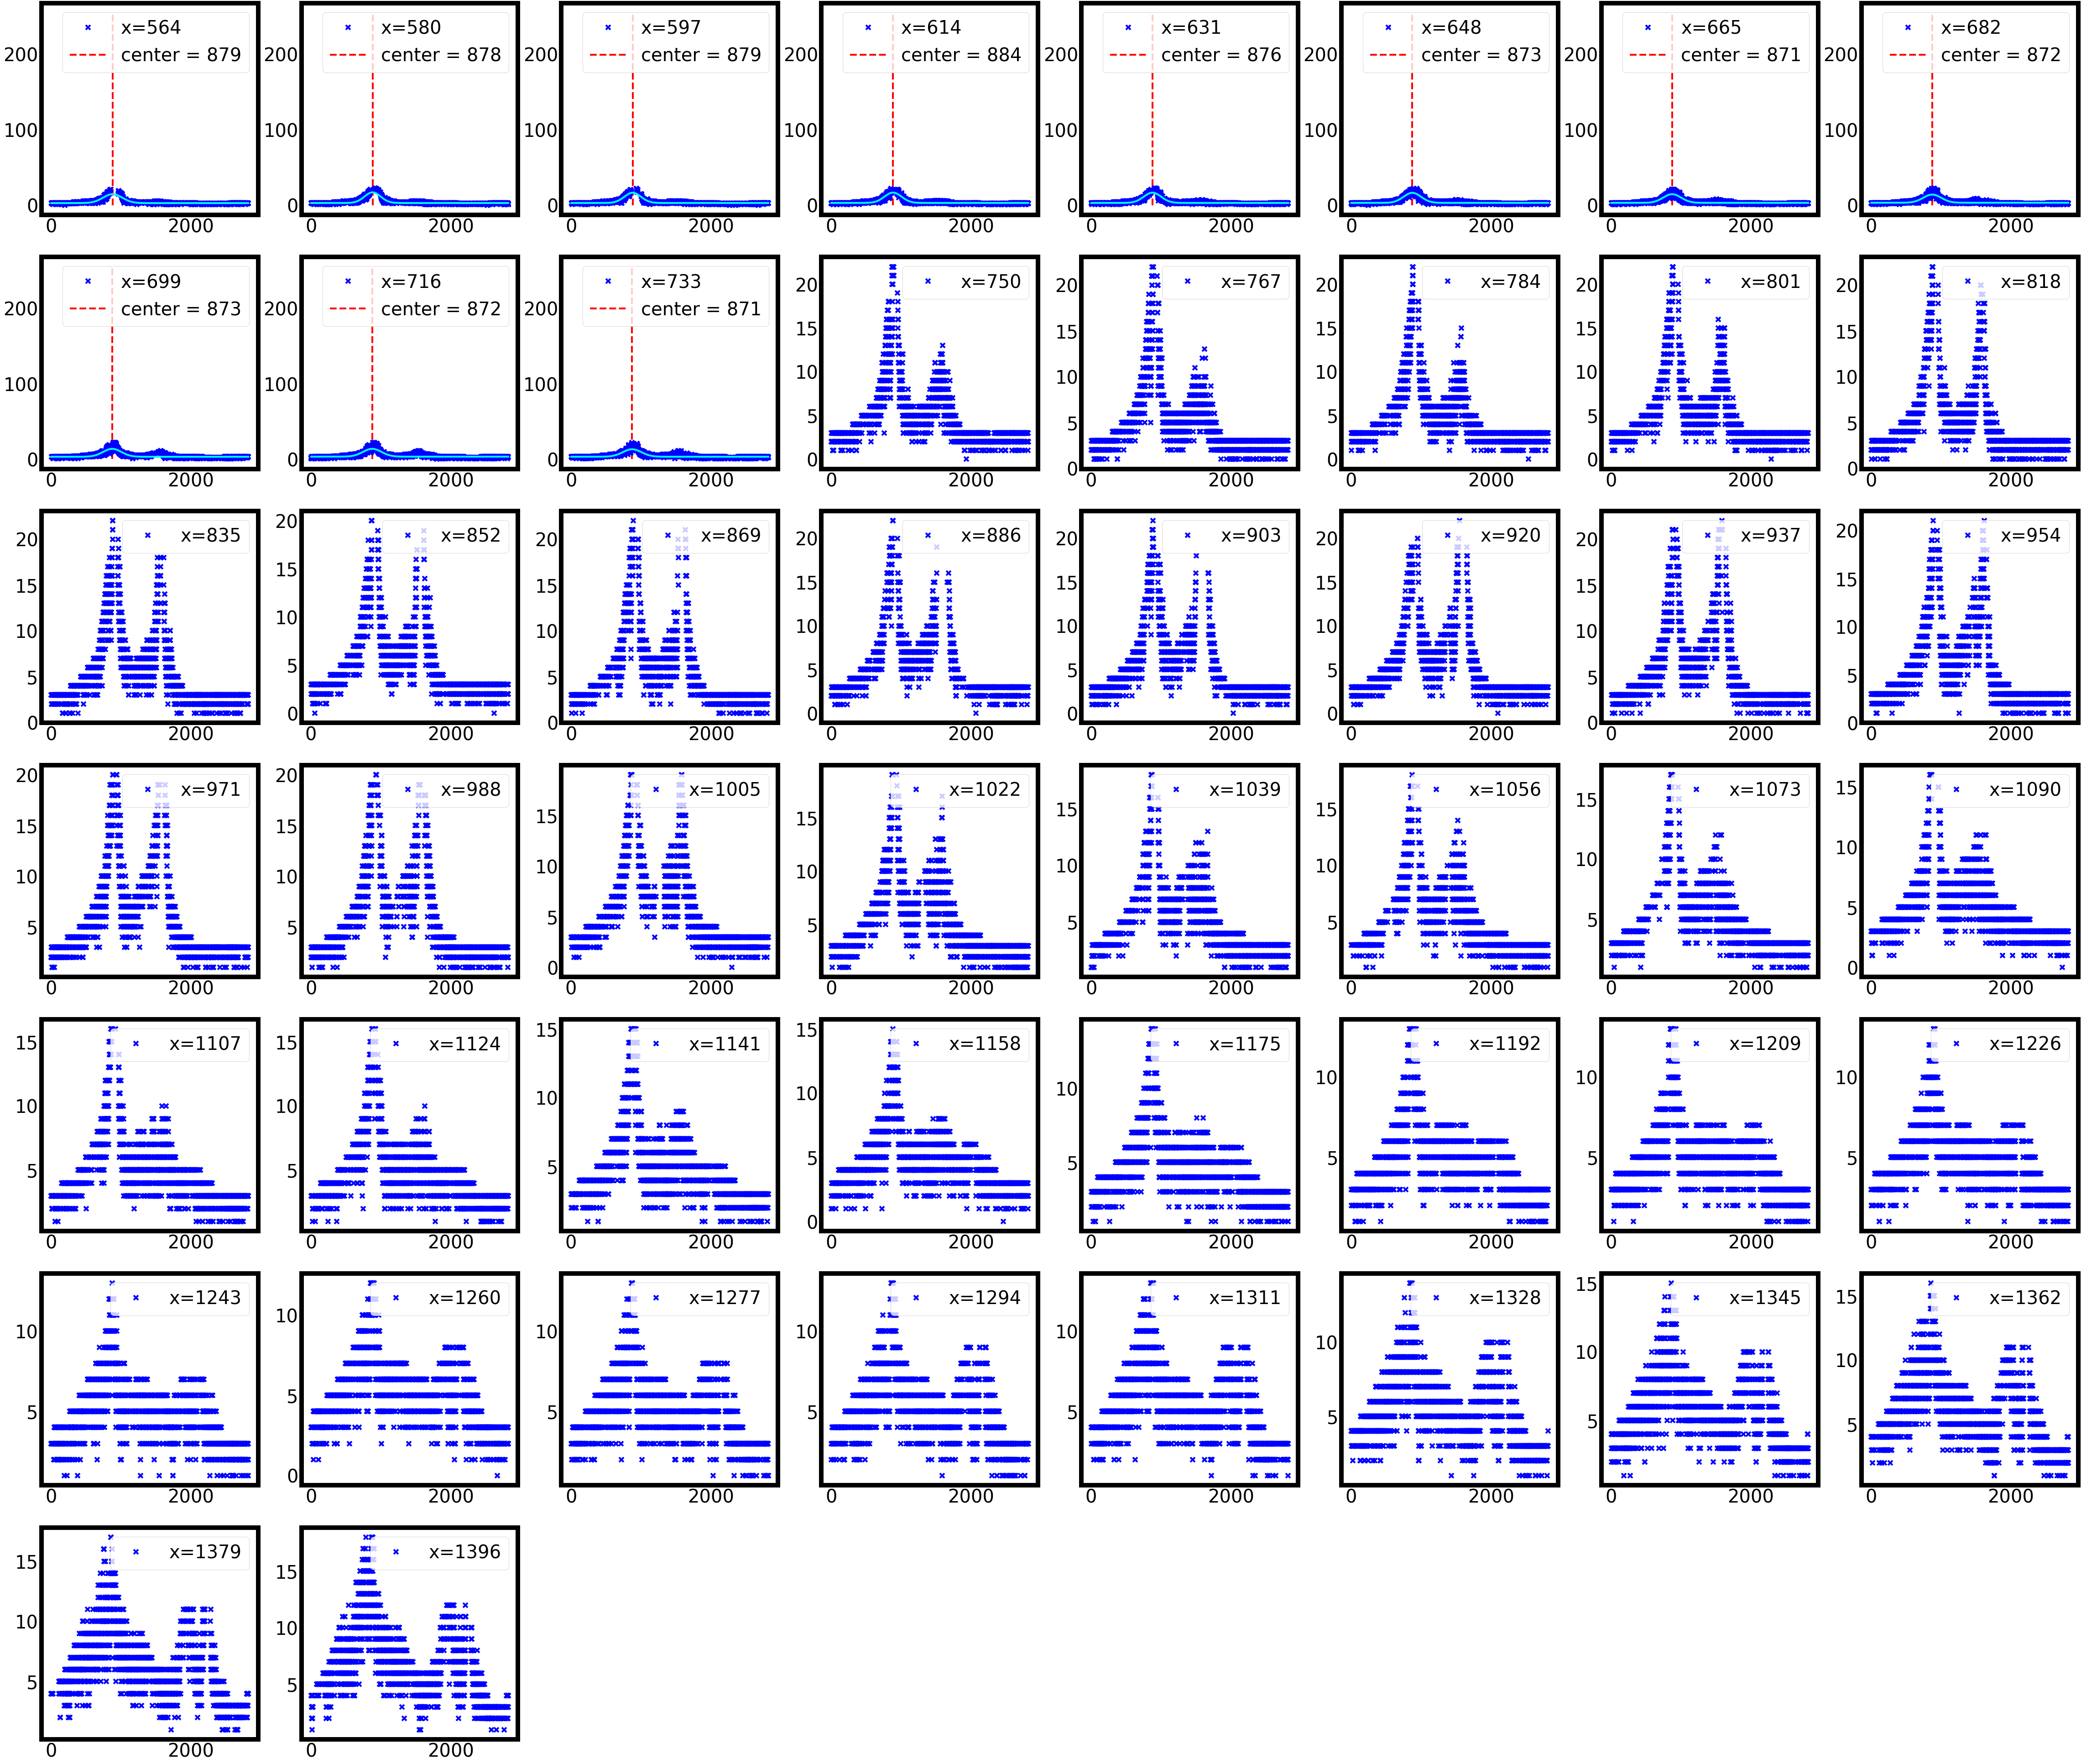

In [4]:
#
# main
#
#arg = sys.argv
#input_figname = arg[1] # full path including dir + file name
figname = os.path.basename(input_figname)
dirname = os.path.dirname(input_figname)
tmp = figname.split("_") # ['TCam', 'ETMX', '01110', '2022', '0328', '102439.png']

#
# only for Kamioka computer
#
# if os.path.isdir("/data2"):
#     outdirname = "/data2/" + tmp[0] + "_fit" + "/" + tmp[1] + "/archive/" + tmp[3] + "/" + tmp[4]
#     dir_base_fit = "/".join(input_figname.split("/")[0:4]).replace("TCam", "TCam_fit")     # /data2/TCam_fit/ETMX
# #
# # for other users 
# #
# else:
outdirname = "./"
dir_base_fit = "./"
outdirname_sym = tmp[1] + "/" # for doing `cd` command, only when there is `/data2` directory
mirror_name = tmp[1]
if mirror_name not in ["ITMX", "ETMX", "ITMY", "ETMY"]:
    message = "error : mirror name (%s) is out of support" % mirror_name
    dump_error_message_and_exit(message, dir_base_fit)
    
config_file = dirname + "/" + figname.split(".")[0] + ".txt" 

if not os.path.isfile(input_figname):
    message = 'error : figure not found. require FULL path to figure.'
    dump_error_message_and_exit(message, dir_base_fit)

if not os.path.isfile(config_file):
    message = 'error : configure file from TCam not found. configuration file should be located in same directory as figure.'
    dump_error_message_and_exit(message, dir_base_fit)
    
if not os.path.exists(outdirname):
    os.makedirs(outdirname)

#    
# extract gain and exposure time from configuration file of TCam
#
gain, T = get_gain_T(dirname, figname)
#print(gain, T)

x_mirror, y_mirror, x_err_mirror, y_err_mirror, r_mirror = get_latest_mirror_center(dir_base_fit, mirror_name)
print(x_mirror, y_mirror, x_err_mirror, y_err_mirror, r_mirror)

#
# run fit
#
flag_output = True
#n_slice      = 250 # 何個飛ばしに分割するか
#n_slice      = 800 # 何個飛ばしに分割するか
n_slice = 50
threshold_center_error = 8 # フィット結果のcenterのエラーが何ピクセル以下なら採用するかのしきい値
x, x_err, y, y_err = fit_image(outdirname, outdirname_sym,
                               dirname, dir_base_fit,
                               figname, mirror_name, gain, T,
                               x_mirror, y_mirror, r_mirror, x_err_mirror, y_err_mirror,
                               n_slice = n_slice, threshold_center_error = threshold_center_error,
                               flag_output=flag_output)

#
# create symbolic link (only for Kamioka computer)
#
create_symbolic_link(figname, outdirname, dir_base_fit, mirror_name)

#
# save fitting results as text and csv files
#
save_textfile(figname, dir_base_fit, x, y, x_err, y_err,
                  x_mirror, y_mirror, r_mirror, x_err_mirror, y_err_mirror,
                  gain, T, mirror_name)

print("fit_beam_center.py done without error.")
print("file = %s" % figname)

In [ ]:
#n_tile_vertical = 8
n_tile_horizon  = 8
step  = 1
x0    = 0    
fname="%s/%s" % (dirname, figname)

img_full = cv2.imread(fname, cv2.IMREAD_UNCHANGED)
height, width, _ = img_full.shape    
img_gray = cv2.cvtColor(img_full, cv2.COLOR_BGR2GRAY)
img      = np.array(img_gray, dtype=float)

# image filtering method
img_ftr = mf.twoD_LowPass(img)
if flag_output:
    fname="%s/lp_%s" % (outdirname, figname)
    cv2.imwrite(fname, img_ftr)

char_axis = ["y", "x"]
directions = ['yoko', 'tate']
return_values = np.zeros(4)
center_values_slice = {}
center_values_ave = {}
center_values_err = {}

In [ ]:
# この範囲のデータはフィットデータから取り除く
x_crop_min = 2080
x_crop_max = 3400
y_crop_min = 820
y_crop_max = 1700

In [ ]:
    for ax_slice in range(2):

#for ax_slice in [1]:

        cut_direction = directions[ax_slice]
        fit_results = []        
        
       # 鏡の内側のみをフィットに使う(pcalをフィットに使わないため)
        r_half = r_mirror/3
        if cut_direction == 'yoko': # y = y_0 で切った時のデータをフィットする。横に切る, n_sliceは何等分するか
            slices = np.linspace(int(y_mirror-r_half), int(y_mirror+r_half), n_slice, dtype=int)
        elif cut_direction == 'tate':  # x = x_0 で切った時のデータをフィットする。縦に切る, n_sliceは何等分するか
            slices = np.linspace(int(x_mirror-r_half), int(x_mirror+r_half), n_slice, dtype=int)
        print(y_mirror - r_half, y_mirror + r_half)
            
        print(slices)

        n_tile_vertical = math.ceil(len(slices) / n_tile_horizon)         
        
        fig = plt.figure(figsize=[100, n_tile_vertical*10])           

        for i_slice in range(n_slice):
        #for i_slice in range(10, 49):
            ii_slice = slices[i_slice]

            print(i_slice, ii_slice)
            
            if cut_direction == 'yoko': # y = y_0 で切った時のデータをフィットする。横に切る

                fit_color = 'pink'

                xdata     = np.arange(width)
                ydata     = img[ii_slice,:]
                ydata_ftr = img_ftr[ii_slice,:]

                index     = np.ones(len(ydata), dtype=bool)

                index[ydata > ydata_ftr] = False 
                
                # index[(xdata < (x_mirror-r_half))] = False
                # index[((x_mirror+r_half) < xdata)] = False
                
                #xdata     = xdata[((x_mirror-r_half) <= xdata) & (xdata <= (x_mirror+r_half))]
                                              
                if y_crop_min <= ii_slice <= y_crop_max:
                    print("hoge")
                    index[( xdata < x_crop_min ) | (x_crop_max < xdata)] = False
                    # ydata     = ydata
                    # ydata_ftr = ydata_ftr[( xdata < x_crop_min ) & (x_crop_max < xdata)]
                    # xdata     = xdata[( xdata < x_crop_min ) & (x_crop_max < xdata)]

            elif cut_direction == 'tate':  # x = x_0 で切った時のデータをフィットする。縦に切る

                fit_color = 'cyan'
                
                xdata     = np.arange(height)
                ydata     = img[:, ii_slice]
                ydata_ftr = img_ftr[:, ii_slice]

                index     = np.ones(len(ydata), dtype=bool)

                index[ydata > ydata_ftr] = False 

                # index[(xdata < (y_mirror-r_half))] = False
                # index[((y_mirror+r_half) < xdata)] = False
#                index[(xdata < (y_mirror-r_half)) | ((y_mirror+r_half) < xdata)] = False
#                index[((y_mirror-r_half) <= xdata) & (xdata <= (y_mirror+r_half))] = False
                
                
#                 ydata     = img[:, ii_slice]
#                 ydata     = ydata[((y_mirror-r_half) <= xdata) & (xdata <= (y_mirror+r_half))]
#                 ydata_ftr = img_ftr[:, ii_slice]
#                 ydata_ftr = ydata_ftr[((y_mirror-r_half) <= xdata) & (xdata <= (y_mirror+r_half))]
#                 xdata = np.arange(len(ydata))

                if x_crop_min <= ii_slice <= x_crop_max:
                    print("hoge")
                    index[( xdata < y_crop_min ) | (y_crop_max < xdata)] = False
            
                    # ydata     = ydata[( y_crop_min <= xdata) & (xdata <= y_crop_max)]
                    # ydata_ftr = ydata_ftr[( y_crop_min <= xdata) & (xdata <= y_crop_max)]
                    # xdata     = xdata[( y_crop_min <= xdata) & (xdata <= y_crop_max)]
                    # print(ydata)

            #xdata = np.arange(len(ydata))
            #index = np.ones(len(ydata), dtype=bool)
            # ydata > ydata_ftr の部分のデータを落とす            

            print("index = %d / %d" % (len(index[index==True]), len(index)))
            
            xdata_fit = xdata[index]
            ydata_fit = ydata[index]                    

            print(xdata)
            #print(xdata_fit)
            # print(ydata)
            # print(len(xdata))
            # print(len(ydata))
            print(len(ydata_ftr))
            print(len(xdata_fit))
            print(len(ydata_fit))

            plt.subplot(n_tile_vertical, n_tile_horizon, i_slice+1)        
            plt.plot(xdata, ydata, c="gray", marker="x",
                     markersize=10, markeredgewidth=4, linewidth=0)
                       
            if len(xdata_fit) > 50:
                popt, pcov = mf.get_peak(xdata_fit, ydata_fit)

                plt.plot(xdata_fit, ydata_fit, label="%s=%d" % (char_axis[ax_slice], ii_slice), c="blue", marker="x",
                     markersize=10, markeredgewidth=4, linewidth=0)                                                         
                
                center_err = np.diag(pcov)[2]
                if(center_err < threshold_center_error):
                    result = []
                    result.append(slices[i_slice]) # これが今のsliceの値
                    for i in range(len(popt)):
                        result.append(popt[i]) # 最初のフィットパラメーター [amplitude, width, center, background]
                        result.append(np.diag(pcov)[i]) # 標準偏差 std error
                    fit_results.append(result)

                    plt.plot(np.array(xdata), mf.ClippedGaussian(xdata, *popt), c=fit_color, linewidth=4)
                    plt.vlines(popt[2], 0, 255, "red", label="center = %d" % popt[2], linestyles='dashed', linewidth=4) # vlines        
            plt.legend(loc="lower left")                

        fig.patch.set_facecolor('white')
        outname = "fit_%s_%s.png" % (figname.split(".")[0], cut_direction)
        plt.savefig(outname, bbox_inches='tight', pad_inches=0.5)          

In [ ]:
x_slice[(x_slice>2000) & (x_slice < 2500)]

In [ ]:
x = 100
if 10 <= x <= 120:
    print("aaa")